# Import libraries and modules

In [1]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

import pysindy.pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'   #'LSODA'
integrator_keywords['rtol'] = 1.0  # 1e-3
integrator_keywords['atol'] = 1.0  # 1e-4
integrator_keywords['max_step'] = 0.1

system_size = 100
n_samples_train = 2000
n_samples_test = 1000

poly_order = 3
threshold = 0
dt = 1

Current directory: /u1/ame805/pysindy_fork/simlab_experiments
Root directory: /u1/ame805/pysindy_fork


# Functions

In [2]:
def readExpData(file_path, Nsize=100):
    
    if os.path.isfile(file_path):
        
        # extract data from file using numpy module
        data = np.loadtxt(file_path)
        size = np.shape(data)

        t_data = np.empty(shape=(size[0],))
        # first column of the file is time
        t_data[:] = data[:, 0]

        # remaining data is number of clusters of size n. Index for column i corresponds to number of clusters of size i-1
        # n_data = data[:, 1:Nsize+1]
        #** We just divide the cluster numbers by the volume of the system which is 126^3 (in units of sigma). 
        n_data = data[:, 1:Nsize+1] / (126**3)  ## only the first 'size' (excluding the very first 0) entries to match the kappa coeff
        
        return t_data, n_data
    
    else:
        print(f"Experiment file ({file_path}) does not exist")
        exit()

# Load data

In [3]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)

t_values, N_clusters = readExpData(exp_dir, Nsize=system_size)

# # n_samples_train random indices
# indices = np.random.choice(len(t_values), n_samples_train, replace=False)
# indices = np.sort(indices)
# Linearly spaced indices
indices = np.linspace(0, len(t_values)-1, n_samples_train, dtype=int)
N_clusters_train = N_clusters[indices]
t_values_train = t_values[indices]

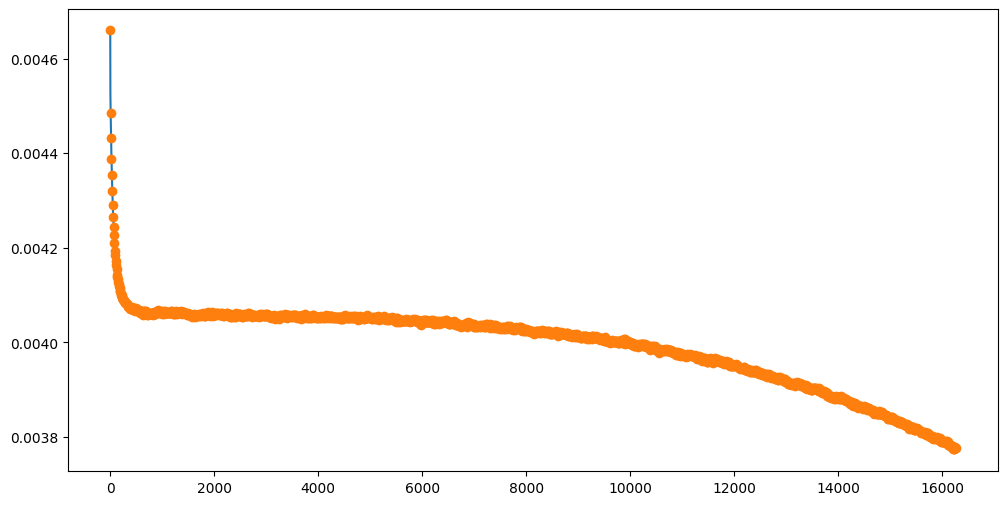

In [4]:
n_to_plot = 1

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_values, N_clusters[:, n_to_plot-1], label=f'Cluster size {n_to_plot}')
# plt.plot(t_values[:n_samples_train], N_clusters[:n_samples_train, n_to_plot-1], label=f'Cluster size {n_to_plot}')
plt.plot(t_values_train, N_clusters_train[:, n_to_plot-1], 'o', label=f'Training data Cluster size {n_to_plot}')

plt.show()

# Build and fit the model

In [5]:
# Fit the model
model = ps.SINDy( 
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(N_clusters_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
                     'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17',
                     'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25',
                     'x26', 'x27', 'x28', 'x29', ...],
      optimizer=STLSQ(threshold=0))

In [6]:
# N_clusters_train
# Find min value gretaer than 0
min_val = np.min(N_clusters_train[N_clusters_train > 0])
min_val

2.4995300883433915e-09

In [7]:
# Print the model
model.print()

(x0)' = -0.031 1 + 30.622 x0 + -40.798 x1 + -386.100 x2 + -145.350 x3 + -35.432 x4 + 4936.355 x5 + 210.186 x6 + 510.462 x7 + -774.252 x8 + -134.240 x9 + -983.951 x10 + 127.048 x11 + 67.256 x12 + -99.765 x13 + -1101.178 x14 + 1230.521 x15 + 645.994 x16 + 444.964 x17 + 264.854 x18 + 229.975 x19 + -1239.114 x20 + 494.240 x21 + 1990.474 x22 + 1515.428 x23 + -696.414 x24 + 924.725 x25 + 744.086 x26 + 969.584 x27 + 3411.241 x28 + -439.174 x29 + 483.376 x30 + 6444.561 x31 + -5329.332 x32 + 4717.027 x33 + 1106.166 x34 + 986.505 x35 + 1230.774 x36 + -1671.753 x37 + -684.152 x38 + -1141.095 x39 + -2327.874 x40 + -3521.652 x41 + -11.951 x42 + 2182.051 x43 + 6285.821 x44 + -3432.383 x45 + -473.898 x46 + 1932.319 x47 + 3886.340 x48 + -2696.702 x49 + -2693.442 x50 + -870.764 x51 + 1834.788 x52 + 1735.518 x53 + 2270.767 x54 + 701.105 x55 + -3100.510 x56 + 4084.668 x57 + -1924.316 x58 + -1827.493 x59 + 3125.256 x60 + 2311.073 x61 + 3518.539 x62 + -2891.928 x63 + -3082.217 x64 + 674.335 x65 + -1858.363

In [8]:
# # Print the model
# # model.print()

# save_folder = 'ck_experiments'
# if not os.path.exists(save_folder):
#     os.makedirs(save_folder)
    
# model.save(save_folder, precision=4)

In [9]:
N_clusters.shape, N_clusters[0].shape

((16257, 100), (100,))

In [10]:
# # integrator_keywords['method'] = 'RK23'
# # integrator_keywords['rtol'] = 1e-4
# # integrator_keywords['atol'] = 1e-6
# integrator_keywords['method'] = 'BDF'
# integrator_keywords['rtol'] = 1e-3
# integrator_keywords['atol'] = 1e-10
# n_samples_test = 1000
# n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], integrator_kws=integrator_keywords)

integrator_keywords['method'] = 'Euler'   # 'RK2'   #'RK4' 
n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], 
                              integrator='fixed_step', integrator_kws=integrator_keywords)

fixed_step {'method': 'Euler', 'rtol': 1.0, 'atol': 1.0, 'max_step': 0.1}
t: 0.0

t: 684.0

In [ ]:
n_sim.shape, t_sim.shape

((32, 100), (32,))

/tmp/ipykernel_374712/759763912.py:11: RuntimeWarning: divide by zero encountered in log
  t_values_log = np.log(t_values)
/tmp/ipykernel_374712/759763912.py:12: RuntimeWarning: divide by zero encountered in log
  t_sim_log = np.log(t_sim)


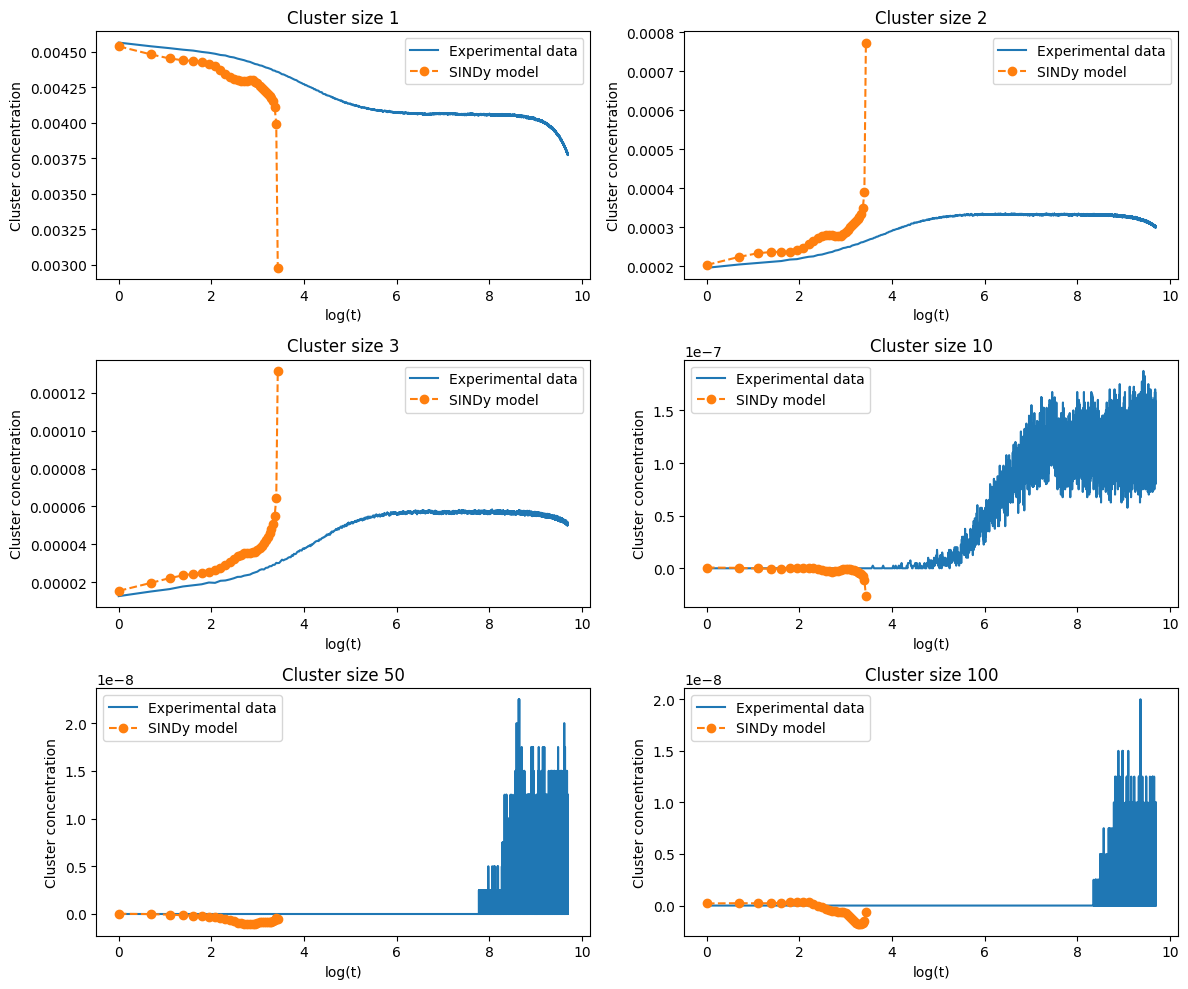

In [ ]:
# List of IDs to plot
ids_to_plot = [1, 2, 3, 10, 50, 100]

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Log the time values
t_values_log = np.log(t_values)
t_sim_log = np.log(t_sim)

for i, n_to_plot in enumerate(ids_to_plot):
    
    if n_to_plot > system_size:
        print(f"Cluster size {n_to_plot} is larger than the system size {system_size}")
        continue
    # Plot the data
    axs[i].plot(t_values_log, N_clusters[:, n_to_plot-1], label=f'Experimental data')
    axs[i].plot(t_sim_log, n_sim[:, n_to_plot-1], label='SINDy model', marker='o', linestyle='dashed')
    axs[i].set_title(f'Cluster size {n_to_plot}')
    axs[i].legend()
    
    axs[i].set_xlabel('log(t)')
    axs[i].set_ylabel('Cluster concentration')

plt.tight_layout()
plt.show()